<a href="https://colab.research.google.com/github/awjumangit/ThinkStats2/blob/master/brunei_simulated_univariate_stacked_lstm_direct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code was rebuilt from the <a href="https://colab.research.google.com/drive/1AcTU1ua4NBtCPEaO8HZZs93FU0iaVAkz#scrollTo=rFDkLjiH7qIX"> old univariate LSTM notebook </a>, to separate the 2 forecasting methods, direct and recursive

Base code for univariate LSTM : https://github.com/krishnaik06/Stock-Market-Forecasting

# Flights Forecasting Using Stacked LSTM

Univariate model and applying direct method in forecasting

# Setup

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set up variables

In [ ]:
# Set drive folder and filepath of flights dataset
# Folder containing output files will be created inside gdrive_folder
gdrive_folder = "/content/drive/MyDrive/Colab Notebooks/BRUNEI/"
filepath = gdrive_folder + "Brunei_forLSTM_daily_until May 2021.xlsx"

# Set the variable to be modelled
target_var = 'OSTotal'                    

# Set the number of rows at the tailend of dataset to be skipped
skipfooter = 0

# Time step for prediction / look back period
time_step = 14

# How many days in the future to predict 
next_n_days = 360

# Set ADB colors for plots
adb_colors = ["#11B6C9", "#EA512A", "#98C641", "#FDB054", "#CECECE"]

## Import packages

In [ ]:
import os
os.environ['PYTHONHASHSEED']=str(1234)          # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
from datetime import datetime
import datetime as dt
import csv

import math
import numpy as np
np.random.seed(1234)                            # 3. Set the `numpy` pseudo-random generator at a fixed value
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=adb_colors)
import seaborn as sns
sns.set(style="whitegrid")
customPalette = sns.set_palette(sns.color_palette(adb_colors))

import random
random.seed(1234)                               # 2. Set the `python` built-in pseudo-random generator at a fixed value
import tensorflow as tf 
tf.random.set_seed(1234)                        # 4. Set the `tensorflow` pseudo-random generator at a fixed value

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from keras.callbacks import ModelCheckpoint, EarlyStopping




## Create output folder

In [ ]:
# datetime object containing current date and time
now = datetime.now()
timestamp = now.strftime("%Y-%m-%d_%H-%M")
directory = gdrive_folder + "brunei_univariate_direct_" + timestamp
os.mkdir(directory)
print("Folder '% s' created" % directory)


Folder '/content/drive/MyDrive/Colab Notebooks/BRUNEI/brunei_univariate_direct_2021-06-17_00-11' created


# Data Exploration

## Load dataset

In [ ]:
df = pd.read_excel(filepath \
          , sheet_name = "Data"
          , skipfooter = skipfooter 
)
df.tail()

,Date,OSOr,OSDes,OSTotal,OSL,OSTotalL,NewCas1,NewCas,TotCas,NewDea,TotDea,VacSm,TotVaccDoses,TotVaccPop,vaccpopsh,fullyvaccpopsh,R0,R01,R02,MALVacSm,MALTotVaccDoses,MALTotVaccPop,MALvaccpopsh,MALfullyvaccpopsh,MALR0,PHIVacSm,PHITotVaccDoses,PHIfullyvac,PHIvaccpopsh,PHIfullyvaccpopsh,PHIR0,SINVacSm,SINTotVaccDoses,SINTotVaccPop,SINvaccpopsh,SINfullyvaccpopsh,SINR0,AUSVacSm,AUSTotVaccDoses,AUSTotVaccPop,AUSvaccpopsh,AUSfullyvaccpopsh,AUSR0,UKVacSm,UKTotVaccDoses,UKTotVaccPop,UKvaccpopsh,UKfullyvaccpopsh,UKR0,ExchRate,GDP,LGDP,GovtExpHealth,Lights,Llights,ChangeLights,Sindex,UK_SI,AUS_SI,SIN_SI,MAL_SI,PHI_SI,CPI,CPIA,CPIH,CPIT,GDPI,GDPIM,GDPIC,GDPIU
877,2021-05-27,2,3,5,0,5,0.0,1.0,241.0,0.0,3.0,2545.0,49371.0,10949.0,0.112852,0.025027,2.502726,NaN,NaN,67954.0,2859864.0,1050452.0,8.836014,3.245542,1.20,150172.0,3466314.0,1029061.0,3.163241,0.939086,1.07,45787.0,3728869.0,2112450.0,63.737613,36.108139,0.686,76420.0,3906668.0,481681.0,15.320338,1.888954,1.22,595836.0,63349252.0,24478052.0,93.317103,36.057583,1.28,NaN,NaN,NaN,NaN,33.844409,3.521774,0.118897,40.74,62.5,47.69,58.33,80.56,71.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
878,2021-05-28,5,3,8,0,8,0.0,0.0,241.0,0.0,3.0,2303.0,49425.0,10967.0,0.112976,0.025068,2.506840,NaN,NaN,69837.0,2933640.0,1077782.0,9.063957,3.329982,1.19,142674.0,3466314.0,1029061.0,3.163241,0.939086,1.10,45725.0,3728869.0,2112450.0,63.737613,36.108139,0.588,79809.0,4031539.0,491319.0,15.810031,1.926750,1.18,594987.0,63989645.0,24914003.0,94.260438,36.699764,1.30,NaN,NaN,NaN,NaN,33.040566,3.497736,-0.023751,40.74,62.5,78.24,58.33,80.56,71.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
879,2021-05-29,0,0,0,0,0,0.0,0.0,241.0,0.0,3.0,2404.0,52775.0,11120.0,0.120633,0.025418,2.541813,NaN,NaN,72721.0,2999036.0,1092648.0,9.266008,3.375913,1.17,135175.0,3466314.0,1029061.0,3.163241,0.939086,1.10,45664.0,3728869.0,2112450.0,63.737613,36.108139,0.490,84379.0,4153149.0,496024.0,16.286935,1.945201,1.16,572132.0,64592019.0,25332851.0,95.147770,37.316751,1.30,NaN,NaN,NaN,NaN,28.756343,3.358858,-0.129666,40.74,62.5,78.24,58.33,80.56,71.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
880,2021-05-30,3,1,4,0,4,0.0,0.0,241.0,0.0,3.0,2487.0,52775.0,11120.0,0.120633,0.025418,2.541813,NaN,NaN,76192.0,2999036.0,1092648.0,9.266008,3.375913,1.15,139889.0,3974350.0,1206371.0,3.626858,1.100893,1.10,45602.0,3728869.0,2112450.0,63.737613,36.108139,0.392,87562.0,4212899.0,497821.0,16.521250,1.952248,1.13,565376.0,64923228.0,25539173.0,95.635660,37.620675,1.30,NaN,NaN,NaN,NaN,33.587919,3.514166,0.168018,40.74,62.5,78.24,58.33,80.56,71.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
881,2021-05-31,0,0,0,0,0,0.0,1.0,242.0,0.0,3.0,2138.0,52775.0,11120.0,0.120633,0.025418,2.541813,NaN,NaN,72659.0,2999036.0,1092648.0,9.266008,3.375913,1.13,141040.0,3974350.0,1206371.0,3.626858,1.100893,1.09,45540.0,3728869.0,2112450.0,63.737613,36.108139,0.294,90078.0,4243600.0,499237.0,16.641646,1.957801,1.12,541564.0,65211877.0,25734719.0,96.060857,37.908726,1.31,NaN,NaN,NaN,NaN,34.320291,3.535737,0.021805,40.74,62.5,78.24,58.33,80.56,71.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Limit dataset to 2019 only

In [ ]:
# UNCOMMENT THIS SECTION TO TRUNCATE DATASET TO 2019 ONLY
# Change the date indicated to adjust the filter for the dataset

df = df[df['Date'] <= '2020-04-29']
df.tail()

,Date,OSOr,OSDes,OSTotal,OSL,OSTotalL,NewCas1,NewCas,TotCas,NewDea,TotDea,VacSm,TotVaccDoses,TotVaccPop,vaccpopsh,fullyvaccpopsh,R0,R01,R02,MALVacSm,MALTotVaccDoses,MALTotVaccPop,MALvaccpopsh,MALfullyvaccpopsh,MALR0,PHIVacSm,PHITotVaccDoses,PHIfullyvac,PHIvaccpopsh,PHIfullyvaccpopsh,PHIR0,SINVacSm,SINTotVaccDoses,SINTotVaccPop,SINvaccpopsh,SINfullyvaccpopsh,SINR0,AUSVacSm,AUSTotVaccDoses,AUSTotVaccPop,AUSvaccpopsh,AUSfullyvaccpopsh,AUSR0,UKVacSm,UKTotVaccDoses,UKTotVaccPop,UKvaccpopsh,UKfullyvaccpopsh,UKR0,ExchRate,GDP,LGDP,GovtExpHealth,Lights,Llights,ChangeLights,Sindex,UK_SI,AUS_SI,SIN_SI,MAL_SI,PHI_SI,CPI,CPIA,CPIH,CPIT,GDPI,GDPIM,GDPIC,GDPIU
480,2020-04-25,0,0,0,0,0,0.0,0.0,138.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.11,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.78,NaN,NaN,NaN,NaN,NaN,1.01,NaN,NaN,NaN,NaN,NaN,1.27,NaN,NaN,NaN,NaN,NaN,0.44,NaN,NaN,NaN,NaN,NaN,1.01,1.415850,3506.491166,8.162371,374.4,39.885160,3.686004,0.064616,58.33,79.63,69.44,36.11,73.15,100.0,1.939612,2.991519,0.012005,-0.170937,1659.805459,1492.97885,80.089636,51.46097
481,2020-04-26,0,0,0,0,0,0.0,0.0,138.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.10,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.79,NaN,NaN,NaN,NaN,NaN,1.04,NaN,NaN,NaN,NaN,NaN,1.20,NaN,NaN,NaN,NaN,NaN,0.47,NaN,NaN,NaN,NaN,NaN,0.99,1.412725,3506.491166,8.162371,374.4,35.053068,3.556863,-0.121150,58.33,79.63,69.44,36.11,73.15,100.0,1.939612,2.991519,0.012005,-0.170937,1659.805459,1492.97885,80.089636,51.46097
482,2020-04-27,0,0,0,0,0,0.0,0.0,138.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.09,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.80,NaN,NaN,NaN,NaN,NaN,1.05,NaN,NaN,NaN,NaN,NaN,1.12,NaN,NaN,NaN,NaN,NaN,0.49,NaN,NaN,NaN,NaN,NaN,0.98,1.414700,3506.491166,8.162371,374.4,30.109824,3.404852,-0.141022,58.33,79.63,69.44,36.11,73.15,100.0,1.939612,2.991519,0.012005,-0.170937,1659.805459,1492.97885,80.089636,51.46097
483,2020-04-28,0,0,0,0,0,0.0,0.0,138.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.09,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.83,NaN,NaN,NaN,NaN,NaN,1.08,NaN,NaN,NaN,NaN,NaN,1.05,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,0.97,1.409600,3506.491166,8.162371,374.4,39.871367,3.685658,0.324198,58.33,79.63,69.44,36.11,73.15,100.0,1.939612,2.991519,0.012005,-0.170937,1659.805459,1492.97885,80.089636,51.46097
484,2020-04-29,0,0,0,0,0,0.0,0.0,138.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.08,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.86,NaN,NaN,NaN,NaN,NaN,1.11,NaN,NaN,NaN,NaN,NaN,1.01,NaN,NaN,NaN,NaN,NaN,0.55,NaN,NaN,NaN,NaN,NaN,0.97,1.407100,3506.491166,8.162371,374.4,28.474664,3.349015,-0.285837,58.33,79.63,69.44,36.11,73.15,100.0,1.939612,2.991519,0.012005,-0.170937,1659.805459,1492.97885,80.089636,51.46097


In [ ]:
df1=df.reset_index()[target_var]
df1.head()

0    19
1    21
2    25
3    21
4    22
Name: OSTotal, dtype: int64

In [ ]:
print("There are", len(df1), "flights observations available")

There are 485 flights observations available


## Plottting dataset

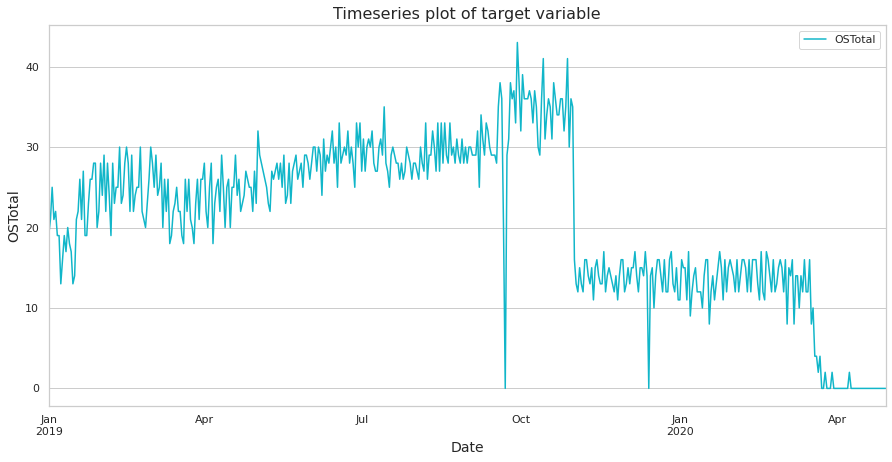

In [ ]:
temp = df[['Date',target_var]]
temp = temp.set_index('Date')
temp.plot(figsize=(15,7))

plt.xlabel('Date', fontsize=14)
plt.ylabel(target_var, fontsize=14)
plt.title("Timeseries plot of target variable", fontsize=16)
plt.grid(axis="x")

plt.savefig('{directory}/target_var_{target_var}.png'.format(directory=directory, target_var=target_var), dpi=300)

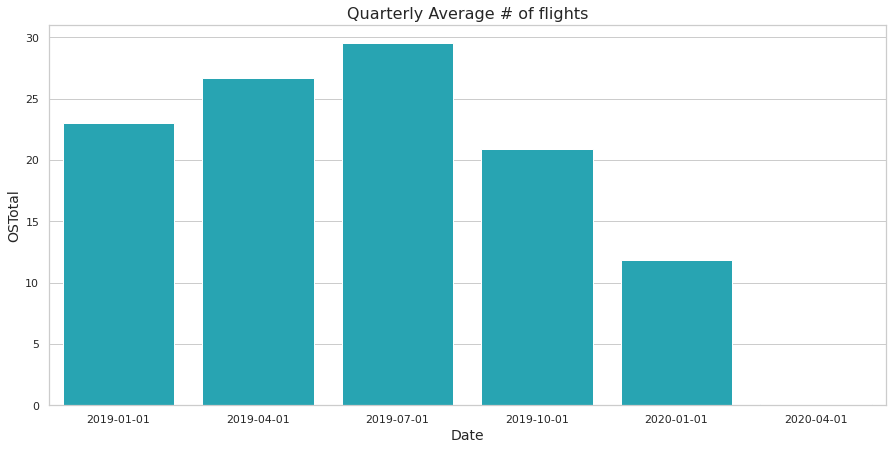

In [ ]:
quarterly_forecast = temp.copy(deep=True)
quarterly_plot = quarterly_forecast.resample('QS').mean().reset_index()
quarterly_plot['Date'] = pd.to_datetime(quarterly_plot['Date']).dt.date

plt.figure(figsize=(15,7))

plt.title("Quarterly Average # of flights", fontsize=16)

plt.ylabel(target_var, fontsize=14)
plt.xlabel("Quarter", fontsize=14)
plt.grid(axis="x")

sns.barplot(x=quarterly_plot['Date'], y=quarterly_plot[target_var], label='Avg Quarterly Forecast', color = adb_colors[0])
plt.show()

## Compute for average values

Will be used later on to compute for rate of recovery

In [ ]:
mean_2019 = df[(df['Date'] < '2020-01-01') & 
               (df['Date'] >= '2019-01-01')
              ][target_var].mean()
mean_2020 = df[(df['Date'] < '2021-01-01') & 
               (df['Date'] >= '2020-01-01')
              ][target_var].mean()
mean_2020_q1 = df[(df['Date'] < '2020-04-01') & 
               (df['Date'] >= '2020-01-01')
              ][target_var].mean()              
mean_2021 = df[(df['Date'] < '2022-01-01') & 
               (df['Date'] >= '2021-01-01')
              ][target_var].mean() 

print(target_var, "mean for 2019:", mean_2019)
print(target_var, "mean for 2020:", mean_2020)
print(target_var, "mean for 2020 Q1:", mean_2020_q1)
print(target_var, "mean for 2021:", mean_2021)             

OSTotal mean for 2019: 25.052054794520547
OSTotal mean for 2020: 8.975
OSTotal mean for 2020 Q1: 11.813186813186814
OSTotal mean for 2021: nan


# Data Preparation

## Splitting data

65-35 train-test split

In [ ]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size

# Testing for a smaller test set
# test_size = 30
# training_size = len(df1)-test_size

train_data,test_data=df1[0:training_size].to_frame(),df1[training_size:len(df1)].to_frame()

In [ ]:
print("Training size:", training_size)
print("Test size:", test_size)

Training size: 315
Test size: 170


In [ ]:
train_dates = df.loc[:training_size, 'Date'] 
test_dates = df.loc[training_size:, 'Date']

## Scale data

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
train_data=scaler.fit_transform(train_data)

In [ ]:
test_data = scaler.transform(test_data)

## Creating a dataset matrix

multiple time series with 100 observations each
- for training set of size 817 -> 716 mini datasets of size 100

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

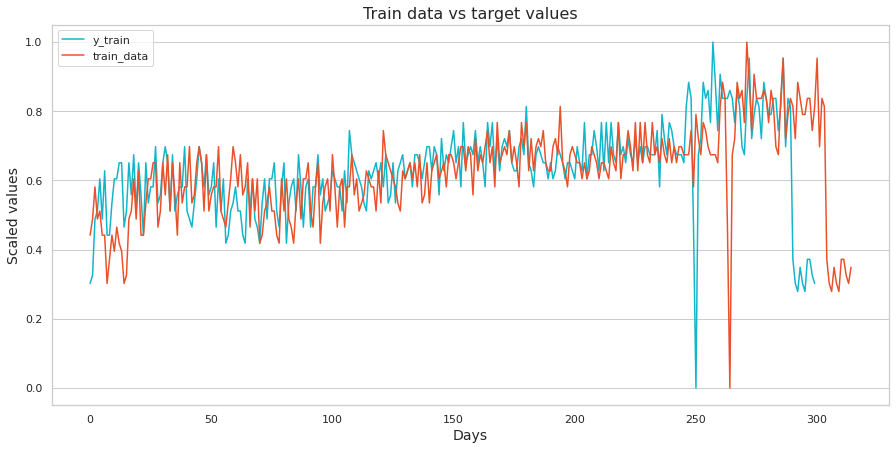

In [ ]:
plt.figure(figsize=(15,7))

plt.title("Train data vs target values", fontsize=16)
plt.ylabel("Scaled values", fontsize=14)
plt.xlabel("Days", fontsize=14)
plt.grid(axis="x")

plt.plot(y_train, label='y_train')
plt.plot(train_data, label='train_data')
plt.legend()
plt.savefig('{directory}/train_data.png'.format(directory=directory), dpi=300)
plt.show()

In [ ]:
print(X_train.shape), print(y_train.shape)

(300, 14)
(300,)


(None, None)

In [ ]:
print(X_test.shape), print(ytest.shape)

(155, 14)
(155,)


(None, None)

In [ ]:
inputs = df1[-time_step:].to_frame()
inputs = scaler.transform(inputs)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# Model Preparation

## Define stacked tensorflow model

Create the Stacked LSTM model


In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(40,return_sequences=True))
model.add(LSTM(30))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 14, 50)            10400     
_________________________________________________________________
lstm_25 (LSTM)               (None, 14, 40)            14560     
_________________________________________________________________
lstm_26 (LSTM)               (None, 30)                8520      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 31        
Total params: 33,511
Trainable params: 33,511
Non-trainable params: 0
_________________________________________________________________


# Model Training

## Model fitting

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test,ytest)
                , epochs = 50  
                , batch_size = 10
                , verbose = 1 
                , callbacks = [es] )

Epoch 1/50
30/30 [==============================] - 5s 53ms/step - loss: 0.0611 - val_loss: 0.0309
Epoch 2/50
30/30 [==============================] - 0s 15ms/step - loss: 0.0138 - val_loss: 0.0316
Epoch 3/50
30/30 [==============================] - 0s 16ms/step - loss: 0.0125 - val_loss: 0.0368
Epoch 4/50
30/30 [==============================] - 0s 16ms/step - loss: 0.0128 - val_loss: 0.0297
Epoch 5/50
30/30 [==============================] - 0s 16ms/step - loss: 0.0127 - val_loss: 0.0267
Epoch 6/50
30/30 [==============================] - 0s 15ms/step - loss: 0.0128 - val_loss: 0.0302
Epoch 7/50
30/30 [==============================] - 0s 16ms/step - loss: 0.0132 - val_loss: 0.0205
Epoch 8/50
30/30 [==============================] - 0s 16ms/step - loss: 0.0137 - val_loss: 0.0220
Epoch 9/50
30/30 [==============================] - 0s 15ms/step - loss: 0.0130 - val_loss: 0.0217
Epoch 10/50
30/30 [==============================] - 0s 16ms/step - loss: 0.0123 - val_loss: 0.0159
Epoch 11/

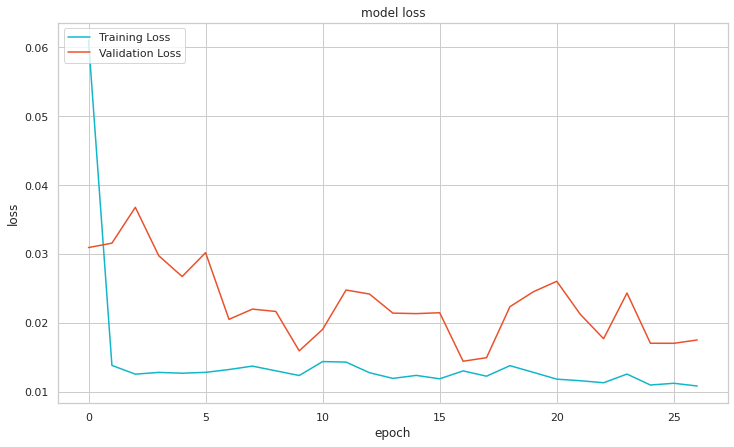

In [ ]:
# summarize history loss
# print(history.history.keys())
# print(history.history)
# print(history.history['val_loss'])
# print(history.history['loss'])

plt.figure(figsize=(12,7))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')

plt.savefig('{directory}/model_loss.png'.format(directory=directory), dpi=300)

plt.show()

### Save model

In [ ]:
savefile = "{directory}/model_{timestamp}".format(directory=directory,timestamp=timestamp)
model.save(savefile, save_format="h5")
# model.model.save('model')

# Model Evaluation

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

## Error Metrics

MSE, RMSE, MAPE, and MASE

In [ ]:
## Calculate RMSE performance metrics on training set
math.sqrt(mean_squared_error(y_train,train_predict))

26.246727629473277

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

15.008772014077183

In [ ]:
inv_y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
inv_y_test = scaler.inverse_transform(ytest.reshape(-1, 1))

mse_train = mean_squared_error(inv_y_train, train_predict)
print("RMSE on Training set:", np.sqrt(mse_train))
print("MSE on Training set:", mse_train)

mae_train = mean_absolute_error(inv_y_train, train_predict)
print("MAE on Training set:", mae_train)

RMSE on Training set: 4.392923919139978
MSE on Training set: 19.29778055935214
MAE on Training set: 3.0171434720357264


In [ ]:
mse_test = mean_squared_error(inv_y_test, test_predict)
print("RMSE on Test set:", np.sqrt(mse_test))
print("MSE on Test set:", mse_test)

mae_test = mean_absolute_error(inv_y_test, test_predict)
print("MAE on Test set:", mae_test)

RMSE on Test set: 5.690264195071119
MSE on Test set: 32.37910660970837
MAE on Test set: 4.6551509088085545


In [ ]:
error_table = pd.DataFrame({'error_metric': ['MAE on Training set', 'MSE on Training set', 'RMSE on Training set'
                              , 'MAE on Test set', 'MSE on Test set', 'RMSE on Test set']
                            , 'value': [mae_train, mse_train, np.sqrt(mse_train), mae_test, mse_test, np.sqrt(mse_test)]})

error_table

,error_metric,value
0,MAE on Training set,3.017143
1,MSE on Training set,19.297781
2,RMSE on Training set,4.392924
3,MAE on Test set,4.655151
4,MSE on Test set,32.379107
5,RMSE on Test set,5.690264


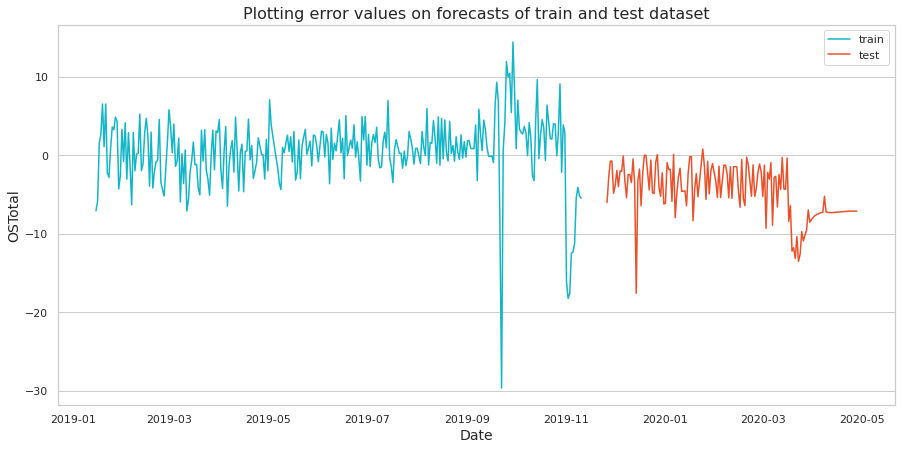

In [ ]:
look_back = time_step

train_error = df[['Date', target_var]].copy(deep=True)
train_error[target_var] = np.nan

(train_error.loc[look_back:len(train_predict)+look_back-1, target_var]) = ((inv_y_train-train_predict)[:,0])

test_error = df[['Date', target_var]].copy(deep=True)
test_error[target_var] = np.nan

test_error.loc[len(train_predict)+(look_back*2)+1:len(df1)-2, target_var] = (inv_y_test-test_predict)[:,0]

plt.figure(figsize=(15,7))
sns.lineplot(x=train_error['Date'], y=train_error[target_var], label='train')
sns.lineplot(x=test_error['Date'], y=test_error[target_var], label='test')

plt.title('Plotting error values on forecasts of train and test dataset', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel(target_var, fontsize=14)

plt.legend()
plt.grid(axis="x")

plt.savefig('{directory}/train_test_data_errors.png'.format(directory=directory), dpi=300, bbox_inches = 'tight', pad_inches=1)

plt.show()

## MASE

https://github.com/CamDavidsonPilon/Python-Numerics/blob/master/TimeSeries/MASE.py

In [ ]:
def MASE(training_series, testing_series, prediction_series):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    
    parameters:
        training_series: the series used to train the model, 1d numpy array
        testing_series: the test series to predict, 1d numpy array or float
        prediction_series: the prediction of testing_series, 1d numpy array (same size as testing_series) or float
        absolute: "squares" to use sum of squares and root the result, "absolute" to use absolute values.
    
    """
    # print "Needs to be tested."
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return round(errors.mean()/d,4)

In [ ]:
# MASE(train_data)
# df1[0:training_size].values, df1[training_size:len(df1)].values
MASE(inv_y_train.reshape(1, -1)[0],  inv_y_test.reshape(1, -1)[0] , test_predict.reshape(1, -1)[0])

1.3891

## Visualizing predictions on train and test dataset

In [ ]:
train_dates_trim = train_dates[time_step+2:]
test_dates_trim = test_dates[time_step+1:]

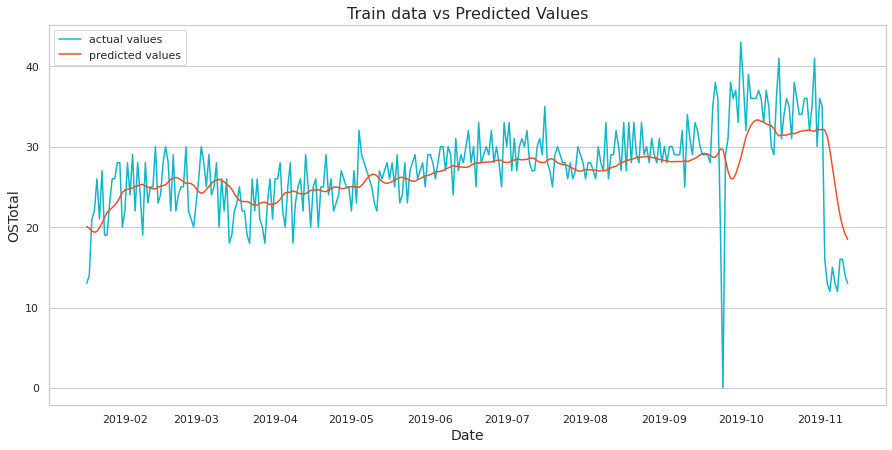

In [ ]:
plt.figure(figsize=(15,7))

plt.plot(train_dates_trim, inv_y_train, label='actual values')
plt.plot(train_dates_trim, train_predict, label='predicted values')

plt.title('Train data vs Predicted Values', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel(target_var, fontsize=14)

plt.legend()
plt.grid(axis="x")

plt.savefig('{directory}/train_vs_predict.png'.format(directory=directory), dpi=300, bbox_inches = 'tight', pad_inches=1)

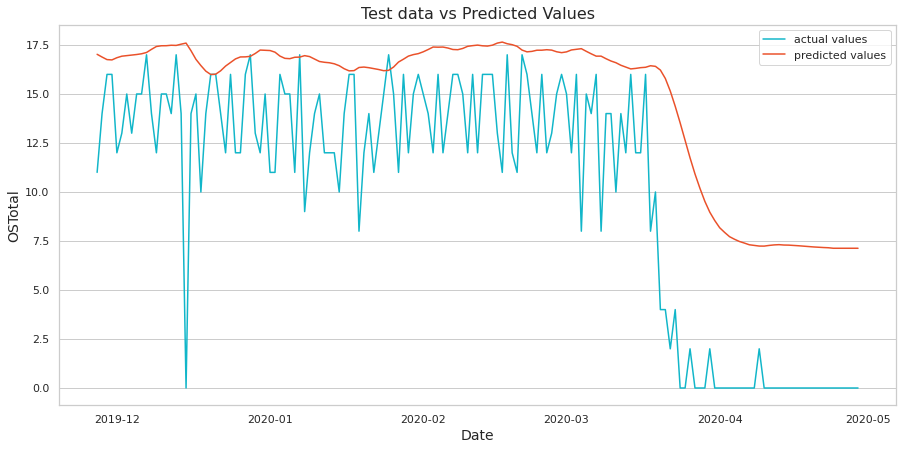

In [ ]:
plt.figure(figsize=(15,7))

plt.plot(test_dates_trim, inv_y_test, label='actual values')
plt.plot(test_dates_trim, test_predict, label='predicted values')

plt.title('Test data vs Predicted Values', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel(target_var, fontsize=14)

plt.legend()
plt.grid(axis="x")

plt.savefig('{directory}/test_vs_predict.png'.format(directory=directory), dpi=300, bbox_inches = 'tight', pad_inches=1)

# Forecasting

In [ ]:
x_input=test_data[len(test_data)- look_back :].reshape(1,-1)
x_input.shape

(1, 14)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

## Direct forecasting for next n days

In [ ]:
# demonstrate prediction for next n days
from numpy import array


lst_output=[]
n_steps = look_back
i=0
while(i < next_n_days):
    
    if(len(temp_input) > look_back):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

# print(lst_output)

In [ ]:
day_new=np.arange(1,look_back + 1)
day_pred=np.arange(look_back + 1,look_back + 1 + next_n_days)

In [ ]:
day_new = test_dates[- look_back :]
day_pred = pd.bdate_range(start=test_dates.max(),periods=next_n_days, freq="B")

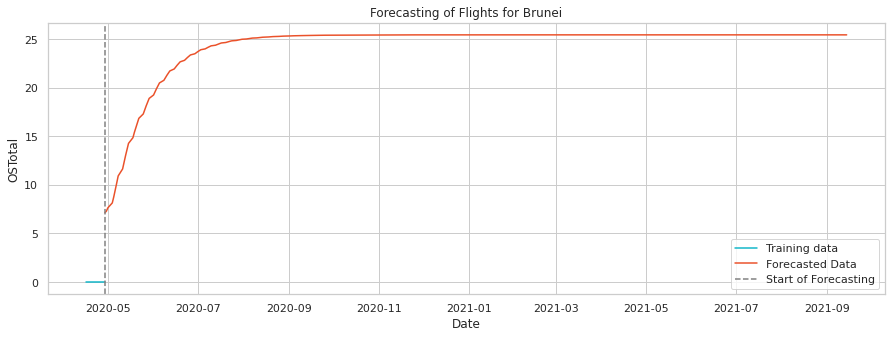

In [ ]:
fig = plt.figure(figsize=(15,5))
ax = fig.subplots() # main axes


ax.plot(day_new,(df1[len(df1) - look_back:].to_frame()), label = 'Training data')
ax.plot(day_pred,scaler.inverse_transform(lst_output), label= 'Forecasted Data')
ax.axvline(x=test_dates.max(), linestyle='--', color='grey', label = 'Start of Forecasting')

plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel(target_var)
ax.set_title('Forecasting of Flights for Brunei')

plt.savefig('{directory}/forecasting_flights_next_{n}_days.png'.format(directory=directory, n=next_n_days), dpi=300, bbox_inches = 'tight', pad_inches=1)

plt.show()

In [ ]:
predicted_values = pd.concat([pd.DataFrame(day_pred), pd.DataFrame(scaler.inverse_transform(lst_output))], axis=1)
predicted_values.columns = ['Date', target_var]
predicted_values

,Date,OSTotal
0,2020-04-29,7.129099
1,2020-04-30,7.283280
2,2020-05-01,7.626563
3,2020-05-04,8.133161
4,2020-05-05,8.756606
...,...,...
355,2021-09-08,25.428620
356,2021-09-09,25.428620
357,2021-09-10,25.428620
358,2021-09-13,25.428620


### Filtered chart after hitting precovid level

In [ ]:
mean_2019

25.052054794520547

In [ ]:
# Date when precovid level was first reached
date_cutoff =  predicted_values[predicted_values[target_var] > mean_2019]['Date'].min()  
date_cutoff

Timestamp('2020-08-05 00:00:00')

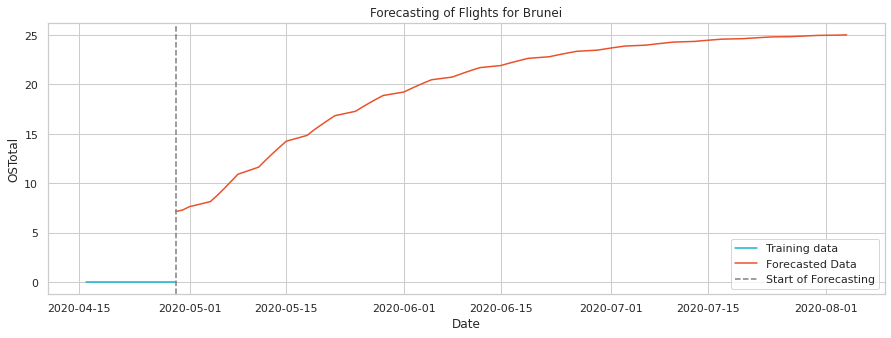

In [ ]:
fig = plt.figure(figsize=(15,5))
ax = fig.subplots() # main axes


ax.plot(day_new,(df1[len(df1) - look_back:].to_frame()), label = 'Training data')
ax.plot(predicted_values[predicted_values['Date'] < date_cutoff]['Date'], predicted_values[predicted_values['Date'] < date_cutoff][target_var], label= 'Forecasted Data')
ax.axvline(x=test_dates.max(), linestyle='--', color='grey', label = 'Start of Forecasting')

plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel(target_var)
ax.set_title('Forecasting of Flights for Brunei')

# plt.savefig('{directory}/forecasting_flights_next_{n}_days.png'.format(directory=directory, n=next_n_days), dpi=300, bbox_inches = 'tight', pad_inches=1)

plt.show()

## Monthly and Quarterly Aggregated Forecast

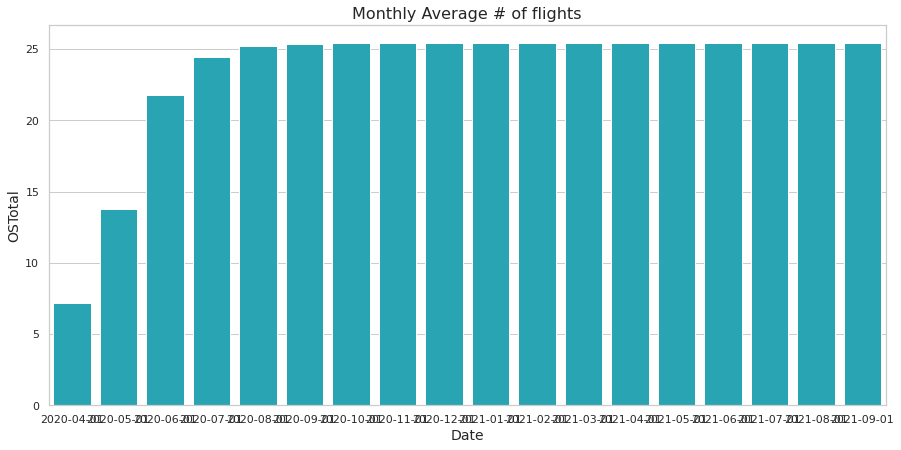

In [ ]:
# Data is aggregated on a monthly level ("MS") and using mean
monthly_forecast = predicted_values.copy(deep=True)
monthly_forecast.set_index('Date', inplace=True)
monthly_plot = monthly_forecast.resample('MS').mean().reset_index()
monthly_plot['Date'] = pd.to_datetime(monthly_plot['Date']).dt.date

plt.figure(figsize=(15,7))

plt.title("Monthly Average # of flights", fontsize=16)

plt.ylabel(target_var, fontsize=14)
plt.xlabel("Month", fontsize=14)
plt.grid(axis="x")

sns.barplot(x=monthly_plot['Date'], y=monthly_plot[target_var], label='Avg Monthly Forecast', color=adb_colors[0])
plt.grid(b=None, which='minor')
plt.savefig('{directory}/monthly_forecast.png'.format(directory=directory), dpi=300, bbox_inches = 'tight', pad_inches=1)
plt.show()

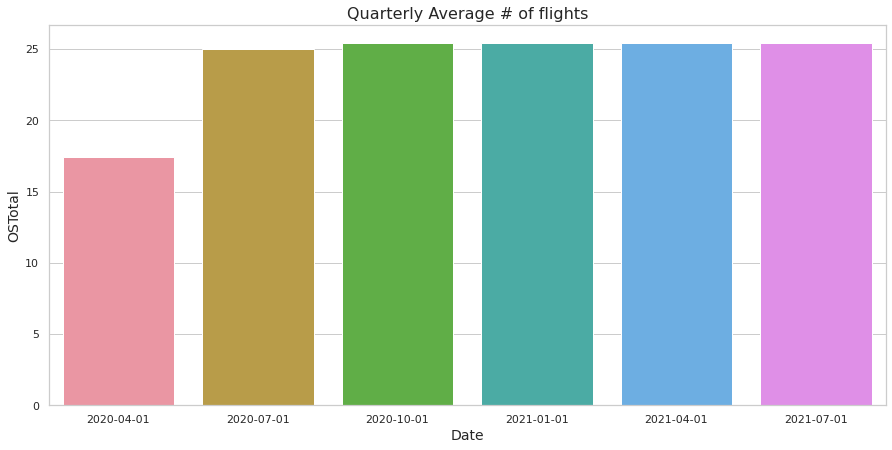

In [ ]:
# Data is aggregated on a quarterly level ("QS") and using mean
quarterly_forecast = predicted_values.copy(deep=True)
quarterly_forecast.set_index('Date', inplace=True)
quarterly_plot = quarterly_forecast.resample('QS').mean().reset_index()
quarterly_plot['Date'] = pd.to_datetime(quarterly_plot['Date']).dt.date

plt.figure(figsize=(15,7))

plt.title("Quarterly Average # of flights", fontsize=16)

plt.ylabel(target_var, fontsize=14)
plt.xlabel("Quarter", fontsize=14)
plt.grid(axis="x")

sns.barplot(x=quarterly_plot['Date'], y=quarterly_plot[target_var], label='Avg Quarterly Forecast')
plt.savefig('{directory}/quarterly_forecast.png'.format(directory=directory), dpi=300, bbox_inches = 'tight', pad_inches=1)
plt.show()

##  Compute rate of recovery

In [ ]:
print("Rate of recovery using latest month prediction:", round(predicted_values.iloc[-30:][target_var].mean() / mean_2019 * 100, 2), "%")

Rate of recovery using latest month prediction: 101.5 %


In [ ]:
print("Rate of recovery using latest quarter prediction:", round(predicted_values.iloc[-90:][target_var].mean() / mean_2019 * 100, 2), "%")

Rate of recovery using latest quarter prediction: 101.5 %


## Days to recover

In [ ]:
# The statement will not print if flight forecast did not reach precovid level
if not isinstance(date_cutoff ,pd._libs.tslibs.nattype.NaTType):
    print("Flights are forecasted to reach pre-covid level by :", date_cutoff.strftime("%d %B, %Y"), "or", \
        predicted_values[predicted_values['Date'] == date_cutoff].index[0], "days after the end of the pandemic") 

Flights are forecasted to reach pre-covid level by : 05 August, 2020 or 70 days after the end of the pandemic


# Saving model results to google drive

In [ ]:
with open('{directory}/parameters.csv'.format(directory=directory), 'w', newline = '') as csvfile:
    my_writer = csv.writer(csvfile, delimiter = ' ')
    my_writer.writerow(['filepath,', filepath])
    my_writer.writerow(['target_var,', target_var])
    my_writer.writerow(['test_size,', test_size])
    my_writer.writerow(['next_n_days,', next_n_days])
    my_writer.writerow(['look_back,', look_back])
    my_writer.writerow(['model.summary,', str(model.summary())])
    

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 14, 50)            10400     
_________________________________________________________________
lstm_25 (LSTM)               (None, 14, 40)            14560     
_________________________________________________________________
lstm_26 (LSTM)               (None, 30)                8520      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 31        
Total params: 33,511
Trainable params: 33,511
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from contextlib import redirect_stdout

with open('{directory}/model_summary.txt'.format(directory=directory), 'w') as f:
    with redirect_stdout(f):
        model.summary()

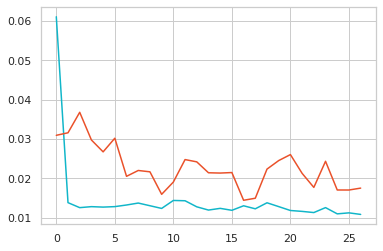

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

In [ ]:
model_loss = pd.DataFrame(data={
    'training_loss' : history.history['loss'], 
    'validation_loss' : history.history['val_loss']}
    )

model_loss.to_csv('{directory}/model_loss.csv'.format(directory=directory))

In [ ]:
predicted_values.to_csv('{directory}/predicted_values.csv'.format(directory=directory))

In [ ]:
# history = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=20,batch_size=20,verbose=1,callbacks=[es])
train_data = pd.concat([pd.DataFrame(X_train[:,:,0]), pd.DataFrame(y_train)], axis =1, )
train_data.to_csv('{directory}/train_data.csv'.format(directory=directory))